In [1]:
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

import tensorflow as tf

In [2]:
max_features = 20000
maxlen = 80
batch_size = 32

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print(f"""훈련 데이터의 개수 : {len(x_train)}""")
print(f"""시험 데이터의 개수 : {len(x_test)}""")

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


훈련 데이터의 개수 : 25000
시험 데이터의 개수 : 25000


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print(f"""학습 데이터의 Shape : {x_train.shape}""")
print(f"""시험 데이터의 Shape : {x_test.shape}""")

학습 데이터의 Shape : (25000, 80)
시험 데이터의 Shape : (25000, 80)


In [5]:
print(x_train[0])

[   15   256     4     2     7  3766     5   723    36    71    43   530
   476    26   400   317    46     7     4 12118  1029    13   104    88
     4   381    15   297    98    32  2071    56    26   141     6   194
  7486    18     4   226    22    21   134   476    26   480     5   144
    30  5535    18    51    36    28   224    92    25   104     4   226
    65    16    38  1334    88    12    16   283     5    16  4472   113
   103    32    15    16  5345    19   178    32]


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_features, 128),
    # (배치 사이즈, 문장 길이, 임베딩 벡터 차원수)
    tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    # (배치 사이즈, LSTM 결과 128차원)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

# Shape=None 은 바뀔수 있는 크기를 말함 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [7]:
sentiment = model.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=3, 
                      validation_data=(x_test,y_test))

# 코랩 사용시 12~13분 소요
# 로컬 실행시 안끝남!!
# AWS notebook 사용시 10분 소요

Epoch 1/3
782/782 [==============================] - 195s 250ms/step - loss: 0.4337 - accuracy: 0.7952 - val_loss: 0.3671 - val_accuracy: 0.8365
Epoch 2/3
782/782 [==============================] - 187s 239ms/step - loss: 0.2545 - accuracy: 0.8991 - val_loss: 0.3662 - val_accuracy: 0.8369
Epoch 3/3
782/782 [==============================] - 184s 235ms/step - loss: 0.1671 - accuracy: 0.9374 - val_loss: 0.4753 - val_accuracy: 0.8134


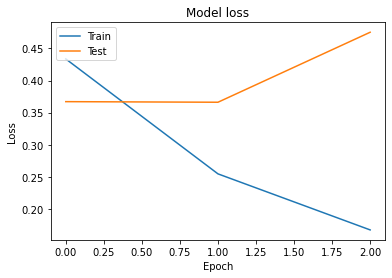

In [8]:
import matplotlib.pyplot as plt

plt.plot(sentiment.history['loss'])
plt.plot(sentiment.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

In [9]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 17s 22ms/step - loss: 0.4753 - accuracy: 0.8134
Test score: 0.4753258228302002
Test accuracy: 0.8133599758148193


In [14]:
# https://datascience.stackexchange.com/a/79832
predict = (model.predict(x_test) > 0.5).astype("int32")
predict_classes=predict.reshape(len(x_test))

In [18]:
# https://www.kaggle.com/code/vincentman0403/sentimental-analysis-on-imdb-by-lstm/notebook

def get_original_text(i):
    word_to_id = imdb.get_word_index()
    word_to_id = {k:(v+3) for k,v in word_to_id.items()}
    word_to_id["<PAD>"] = 0
    word_to_id["<START>"] = 1
    word_to_id["<UNK>"] = 2

    id_to_word = {value:key for key,value in word_to_id.items()}
    return ' '.join(id_to_word[id] for id in x_test[i])

In [19]:
SentimentDict={1:'positive', 0:'negative'}
def display_test_sentiment(i):
    print(get_original_text(i))
    print('label: ', SentimentDict[y_test[i]], ', prediction: ', SentimentDict[predict_classes[i]])

In [20]:
# 3번 리뷰 테스트
display_test_sentiment(3)  # label:  negative , prediction:  negative

angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are impossibly involved with the actions on the screen so then why the hell can't we have night vision
label:  negative , prediction:  negative
